In [401]:
import torch
from tqdm.notebook import tqdm

In [402]:
torch.cuda.is_available()

True

In [403]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [404]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,),(.5,))])

In [405]:
trainset = torchvision.datasets.MNIST('./data',download=True, train=True,transform=transform)
testset = torchvision.datasets.MNIST('./data',download=True,train=False,transform=transform)

In [406]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [408]:
device = torch.device("cuda:0")

In [409]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(784,10,bias=False)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        return self.soft(self.linear(self.flatten(x)))

LR = Net()
LR.to(device)

Net(
  (flatten): Flatten()
  (linear): Linear(in_features=784, out_features=10, bias=False)
  (soft): Softmax(dim=1)
)

In [410]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(LR.parameters(), lr=.001, momentum=0.9)

In [411]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad() # initialize gradient calculation - we will do a batch of 4
        outputs = LR(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[{:d}, {:5d}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Done')

[1,  2000] loss: 1.887
[1,  4000] loss: 1.695
[1,  6000] loss: 1.677
[1,  8000] loss: 1.666
[1, 10000] loss: 1.659
[1, 12000] loss: 1.636
[1, 14000] loss: 1.600
[2,  2000] loss: 1.591
[2,  4000] loss: 1.583
[2,  6000] loss: 1.588
[2,  8000] loss: 1.579
[2, 10000] loss: 1.575
[2, 12000] loss: 1.572
[2, 14000] loss: 1.575
[3,  2000] loss: 1.572
[3,  4000] loss: 1.570
[3,  6000] loss: 1.565
[3,  8000] loss: 1.567
[3, 10000] loss: 1.567
[3, 12000] loss: 1.568
[3, 14000] loss: 1.560
[4,  2000] loss: 1.561
[4,  4000] loss: 1.561
[4,  6000] loss: 1.561
[4,  8000] loss: 1.562
[4, 10000] loss: 1.562
[4, 12000] loss: 1.559
[4, 14000] loss: 1.559
[5,  2000] loss: 1.558
[5,  4000] loss: 1.563
[5,  6000] loss: 1.556
[5,  8000] loss: 1.553
[5, 10000] loss: 1.554
[5, 12000] loss: 1.558
[5, 14000] loss: 1.556
Done


In [412]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = LR(images)
        _, pred = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct += (pred==labels).sum().item()
print(correct/total)

0.9194


In [413]:
LR.linear

Linear(in_features=784, out_features=10, bias=False)

In [414]:
vars(LR.linear)

{'training': True,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[-0.0309, -0.0340, -0.0063,  ...,  0.0132, -0.0376, -0.0098],
                       [-0.0001,  0.0313,  0.0416,  ...,  0.0648,  0.0575,  0.0161],
                       [-0.0162, -0.0476,  0.0148,  ..., -0.0024, -0.0492,  0.0030],
                       ...,
                       [ 0.0180,  0.0207,  0.0104,  ..., -0.0058,  0.0346, -0.0094],
                       [-0.0508, -0.0094, -0.0220,  ..., -0.0426,  0.0031, -0.0332],
                       [ 0.0035, -0.0213, -0.0228,  ...,  0.0047, -0.0161,  0.0411]],
                      device='cuda:0', requires_grad=True)),
              ('bias', None)]),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'in_features': 784,
 'out_features': 10}

In [418]:
filters = LR.linear._parameters['weight'].cpu().detach()

In [419]:
images = [filters[i,:].reshape(28,28) for i in range(10)]


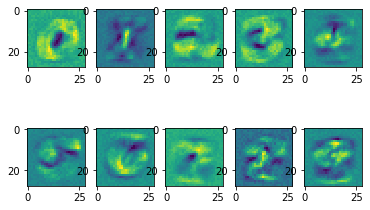

<Figure size 720x720 with 0 Axes>

In [420]:
fig, axes = plt.subplots(2,5)
plt.figure(figsize=(10,10))
for i in range(10):
    axes[i//5,i%5].imshow(images[i].numpy())

In [421]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(784,200,bias=False)
        self.hidden = nn.Linear(200,10,bias=False)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        flat = self.flatten(x)
        lin = self.linear(flat)
        hid = self.hidden(F.relu(lin))
        soft = self.soft(hid)
        return soft

MLP = Net()
MLP.to(device)
print(MLP)        

Net(
  (flatten): Flatten()
  (linear): Linear(in_features=784, out_features=200, bias=False)
  (hidden): Linear(in_features=200, out_features=10, bias=False)
  (soft): Softmax(dim=1)
)


In [422]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters(), lr=.001)

In [423]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad() # initialize gradient calculation - we will do a batch of 4
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[{:d}, {:5d}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Done')

[1,  2000] loss: 1.812
[1,  4000] loss: 1.675
[1,  6000] loss: 1.657
[1,  8000] loss: 1.655
[1, 10000] loss: 1.636
[1, 12000] loss: 1.642
[1, 14000] loss: 1.597
[2,  2000] loss: 1.548
[2,  4000] loss: 1.550
[2,  6000] loss: 1.547
[2,  8000] loss: 1.541
[2, 10000] loss: 1.542
[2, 12000] loss: 1.535
[2, 14000] loss: 1.540
[3,  2000] loss: 1.537
[3,  4000] loss: 1.538
[3,  6000] loss: 1.541
[3,  8000] loss: 1.532
[3, 10000] loss: 1.528
[3, 12000] loss: 1.532
[3, 14000] loss: 1.531
Done


In [424]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = MLP(images)
        _, pred = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct += (pred==labels).sum().item()
print(correct/total)

0.9395
